In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import os
import gc
import time
import importlib
import sklearn.preprocessing as pp
import sklearn.model_selection as ms
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

from recommender import item_based, dummy as dummy_recommender, preprocessing as rpp, model_selection as rms,\
    tools as rtools
import tag_genome_builder as tg_builder
from tag_genome_builder import model_selection as ms_tg_builder

from lib import tools
import config
import config_tag_recommender
def reload():
    importlib.reload(item_based)
    importlib.reload(dummy_recommender)
    importlib.reload(config)
    importlib.reload(tg_builder)
    importlib.reload(rpp)
    importlib.reload(rms)
    importlib.reload(tools)
    importlib.reload(config_tag_recommender)
    importlib.reload(ms_tg_builder)
    importlib.reload(rtools)
    

# input params

In [2]:
str_aggregated_path = config_tag_recommender.str_aggregated_path
str_genome_scores = config_tag_recommender.str_genome_scores
str_tag_ids = config_tag_recommender.str_tag_ids
str_rating_path = config_tag_recommender.str_rating_path
str_data_folder = config_tag_recommender.str_data_folder
minimum_no_of_frames = config_tag_recommender.minimum_no_of_frames
number_of_tag_per_movie = config_tag_recommender.number_of_tag_per_movie

In [3]:
print('str_aggregated_path =', str_aggregated_path)
print('str_genome_scores =', str_genome_scores)
print('str_tag_ids =', str_tag_ids)
print('str_rating_path =', str_rating_path)
print('str_data_folder =', str_data_folder)
print('str_aggregated_path =', str_aggregated_path)
print('minimum_no_of_frames =', minimum_no_of_frames)
print('number_of_tag_per_movie =', number_of_tag_per_movie)

str_aggregated_path:  ..\..\data\MA14KD_AGGREGATED.csv
str_genome_scores:  ..\..\data\ml-20m\genome-scores.csv
str_tag_ids:  ..\..\data\ml-20m\genome-tags.csv
str_rating_path:  ..\..\data\ml-20m\ratings.csv
str_data_folder:  ..\..\data
str_aggregated_path:  ..\..\data\MA14KD_AGGREGATED.csv
minimum_no_of_frames:  10
number_of_tag_per_movie:  10


# Read inputs

In [4]:
df_tag_ids = pd.read_csv(str_tag_ids, index_col=config.tagId_col)

In [5]:
# df_tag_ids.head()

In [6]:
df_genome = pd.read_csv(str_genome_scores)

In [7]:
df_ratings = pd.read_csv(str_rating_path)

In [8]:
usecols = ['movieId', 'no_key_frames']
for i in range(1,11):
    usecols += [f'f{i}_median', f'f{i}_quartile1', f'f{i}_quartile3', f'f{i}_std'] 
print(len(usecols))
df_agg = pd.read_csv(str_aggregated_path, nrows=None, usecols=usecols, index_col='movieId').sort_index()
df_agg = df_agg[df_agg['no_key_frames'] >= minimum_no_of_frames]
df_agg.dropna(axis=1, thresh=len(df_agg) - 1000, inplace=True)

42


In [9]:
print('The size of datasets before filtering to the same:')
print('VF:', df_agg.shape,'Tag genome:', df_genome[config.movieId_col].nunique())
df_agg, df_genome = tg_builder.Base().filter_tag_and_vf_to_same(df_agg=df_agg, df_genome_scores=df_genome)
print('The size of datasets after filtering to the same:')
print('VF:', df_agg.shape,'Tag genome:', df_genome[config.movieId_col].nunique())

The size of datasets before filtering to the same:
VF: (13923, 39) Tag genome: 10381
The size of datasets after filtering to the same:
VF: (5650, 39) Tag genome: 5650


In [10]:

vf_item_features = rpp.ItemFeature()
vf_item_features.from_dataframe(df_agg)

In [11]:
item_features = rpp.get_item_feature_from_tag_genome(df_genome, number_of_tag_per_movie)

In [12]:
df_ratings_filtered = df_ratings[df_ratings[config.movieId_col].isin(item_features.item_ids)]

# Compute tag genome based on visual features

In [13]:
normalizer = pp.QuantileTransformer(output_distribution='normal')


In [14]:
%%time
df_predicted_tag_genome = ms_tg_builder.cross_val_predict(df_visual_features=df_agg,
                                                          df_genome_scores=df_genome,
                                                          normalizer_vf=normalizer,
                                                          n_splits=10, 
                                                          n_jobs=10)

Wall time: 20 s


In [15]:
item_features_vf_tg = rpp.get_item_feature_from_tag_genome(df_predicted_tag_genome, number_of_tag_per_movie)

# Train test split
## rating dataset and tag item features

In [16]:
reload()
df_rating_train, df_rating_test, item_features_train, item_features_test = \
    rms.train_test_split(df_ratings_filtered, item_features, strategy='sklearn', test_size=.25)

## tag genome computed using visual features

In [17]:
reload()
df_rating_vf_tg_train = df_rating_train
df_rating_vf_tg_test = df_rating_test
item_features_vf_tg_train, item_features_vf_tg_test = \
(item_features_vf_tg.get_item_feature_by_list_of_items(df_rating_train[config.movieId_col].unique()),
item_features_vf_tg.get_item_feature_by_list_of_items(df_rating_test[config.movieId_col].unique()))

## Visual features

In [18]:
vf_normalizer = tg_builder.VisualFeatureNormalizer()
normalizer = pp.QuantileTransformer()
df_agg_train = df_agg.loc[df_rating_train[config.movieId_col].unique()]
df_agg_train_normalized = vf_normalizer.fit_transform(df_agg_train, normalizer)
df_agg_test = df_agg.loc[df_rating_test[config.movieId_col].unique()]
df_agg_test_normalized = vf_normalizer.transform(df_agg_test)

item_features_vf_train = rpp.ItemFeature()
item_features_vf_train.from_dataframe(df_agg_train_normalized)
item_features_vf_test = rpp.ItemFeature()
item_features_vf_test.from_dataframe(df_agg_test_normalized)


# Train the content based recommender and predict on test on VF

In [19]:
recommend_vf = item_based.ItemBasedColabCos()
recommend_vf.fit(df_rating_train, item_features_vf_train)

In [20]:
%%time
test_users = df_rating_test[config.userId_col].unique()
recommendations_vf = recommend_vf.predict_on_list_of_users(test_users, 
                                                           df_rating_test, 
                                                           item_features_vf_test, 
                                                           n_jobs=10)

Wall time: 6min 12s


In [21]:
reload()
df_rating_test = rtools.prepare_recommendations_df(df_rating_test=df_rating_test,
                                                   recommendations=recommendations_vf, 
                                                   prediction_column_suffix='vf')

# Train the content based recommender and predict on test on original tag genome

In [22]:
recommend = item_based.ItemBasedColabCos()
recommend.fit(df_rating_train, item_features_train)

In [23]:
%%time
test_users = df_rating_test[config.userId_col].unique()
recommendations = recommend.predict_on_list_of_users(test_users, df_rating_test, item_features_test, n_jobs=10)

Wall time: 6min 27s


In [24]:
df_rating_test = rtools.prepare_recommendations_df(df_rating_test=df_rating_test,
                                                    recommendations=recommendations, 
                                                    prediction_column_suffix='tg')

# Train the content based recommender and predict on test on VF tag genome

In [25]:
recommend_vf_tg = item_based.ItemBasedColabCos()
recommend_vf_tg.fit(df_rating_vf_tg_train, item_features_vf_tg_train)

In [26]:
%%time
test_users_vf = df_rating_vf_tg_test[config.userId_col].unique()
recommendations_vf_tg = recommend_vf_tg.\
    predict_on_list_of_users(test_users_vf, df_rating_vf_tg_test, item_features_vf_tg_test, n_jobs=10)

Wall time: 6min 38s


In [27]:
df_rating_test = rtools.prepare_recommendations_df(df_rating_test=df_rating_test,
                                                   recommendations=recommendations_vf_tg, 
                                                   prediction_column_suffix='vf_tg')

# Train the baseline recommender and predict on test

In [28]:
recommend_dummy = dummy_recommender.DummyAverageUser()
recommend_dummy.fit(df_rating_train, item_features_train)

In [29]:
%%time
recommendations_dummy = recommend_dummy.predict_on_list_of_users(test_users, 
                                                                 df_rating_test, 
                                                                 item_features_test, 
                                                                 n_jobs=10)


Wall time: 5min 2s


In [30]:
df_rating_test = rtools.prepare_recommendations_df(df_rating_test=df_rating_test,
                                                   recommendations=recommendations_dummy, 
                                                   prediction_column_suffix='average_user')

# looking at the performance

In [31]:
prediction_column_suffixes = []
for c in df_rating_test.filter(regex='rating_predicted').columns:
    c = c.replace('rating_predicted', '')
    c = c[1:] if len(c) > 0 else c
    prediction_column_suffixes.append(c)
prediction_column_suffixes

['vf', 'tg', 'vf_tg', 'average_user']

In [32]:
reload()
df_performance_report = pd.concat([tools.performance_report(df_rating_test, 
                                                           prediction_column_suffix=alg) 
                                  for alg in prediction_column_suffixes]).sort_values('RMSE')
df_performance_report

,Average Score,MAE,RMSE,NRMSE,R2,Std of residuals,Avg of residuals
tg,3.519748,0.693849,0.904146,0.256878,0.266718,0.904174,-0.012882
average_user,3.519748,0.759009,0.971541,0.276026,0.153326,0.972563,-0.000148
vf,3.519748,0.760987,0.971593,0.276041,0.153236,0.972384,0.021458
vf_tg,3.519748,0.764759,0.982500,0.279139,0.134119,0.983897,0.001867


## performance table for copying into Latex

In [33]:
print(df_performance_report.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &  Average Score &       MAE &      RMSE &     NRMSE &        R2 &  Std of residuals &  Avg of residuals \\
\midrule
tg           &       3.519748 &  0.693849 &  0.904146 &  0.256878 &  0.266718 &          0.904174 &         -0.012882 \\
average\_user &       3.519748 &  0.759009 &  0.971541 &  0.276026 &  0.153326 &          0.972563 &         -0.000148 \\
vf           &       3.519748 &  0.760987 &  0.971593 &  0.276041 &  0.153236 &          0.972384 &          0.021458 \\
vf\_tg        &       3.519748 &  0.764759 &  0.982500 &  0.279139 &  0.134119 &          0.983897 &          0.001867 \\
\bottomrule
\end{tabular}



## Some plots

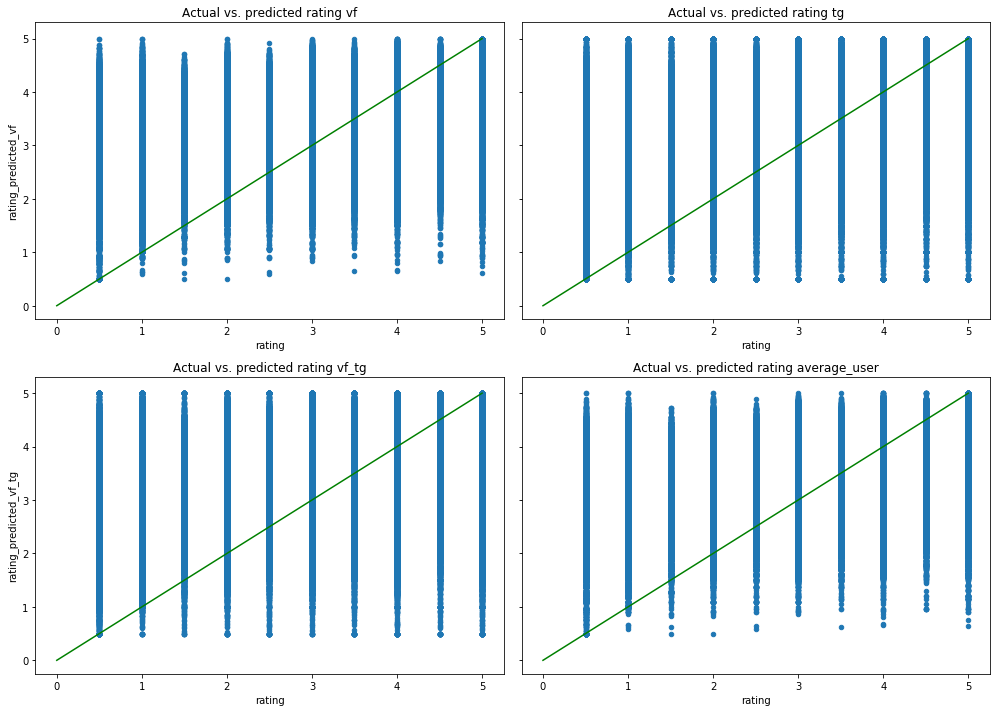

In [34]:
reload()
_ = tools.plot_side_by_side(tools.plot_actual_vs_prediction,
                            df_rating_pred=df_rating_test,
                            prediction_column_suffixes=prediction_column_suffixes)

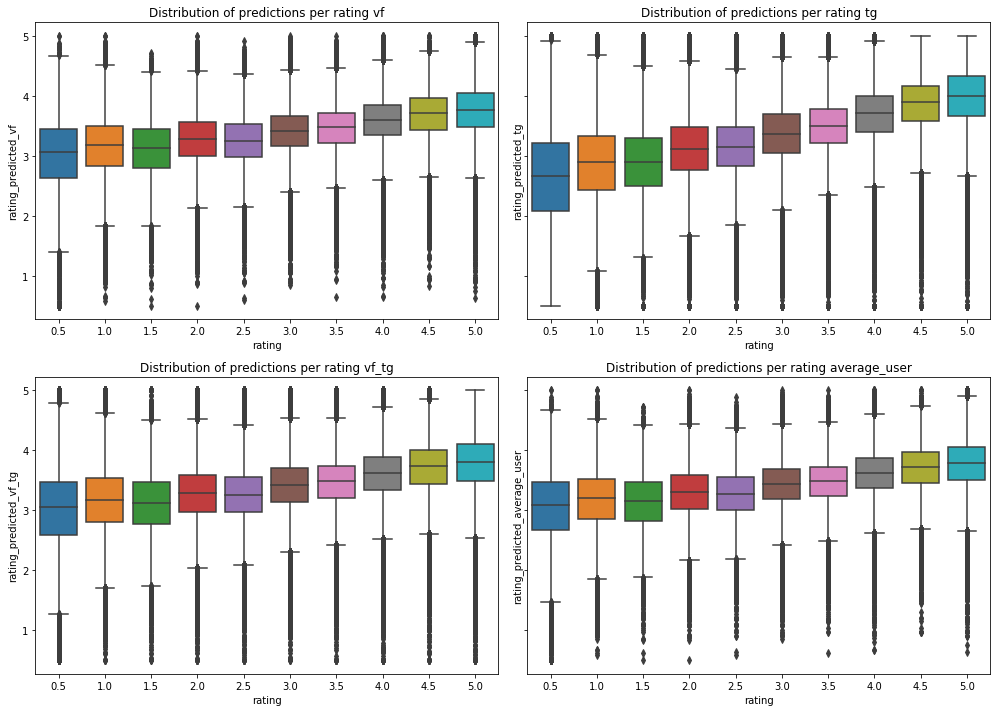

In [36]:
reload()
_ = tools.plot_side_by_side(tools.plot_actual_vs_predicted_boxplot,
                            df_rating_pred=df_rating_test,
                            prediction_column_suffixes=prediction_column_suffixes)

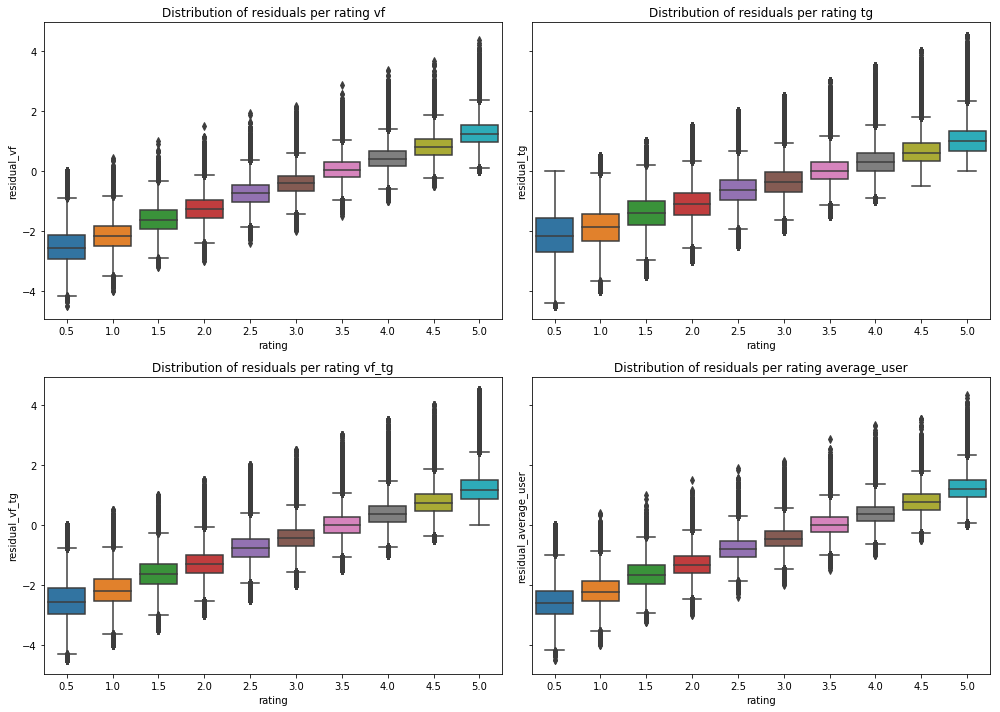

In [37]:
reload()
_ = tools.plot_side_by_side(tools.plot_residual_boxplot,
                            df_rating_pred=df_rating_test,
                            prediction_column_suffixes=prediction_column_suffixes)

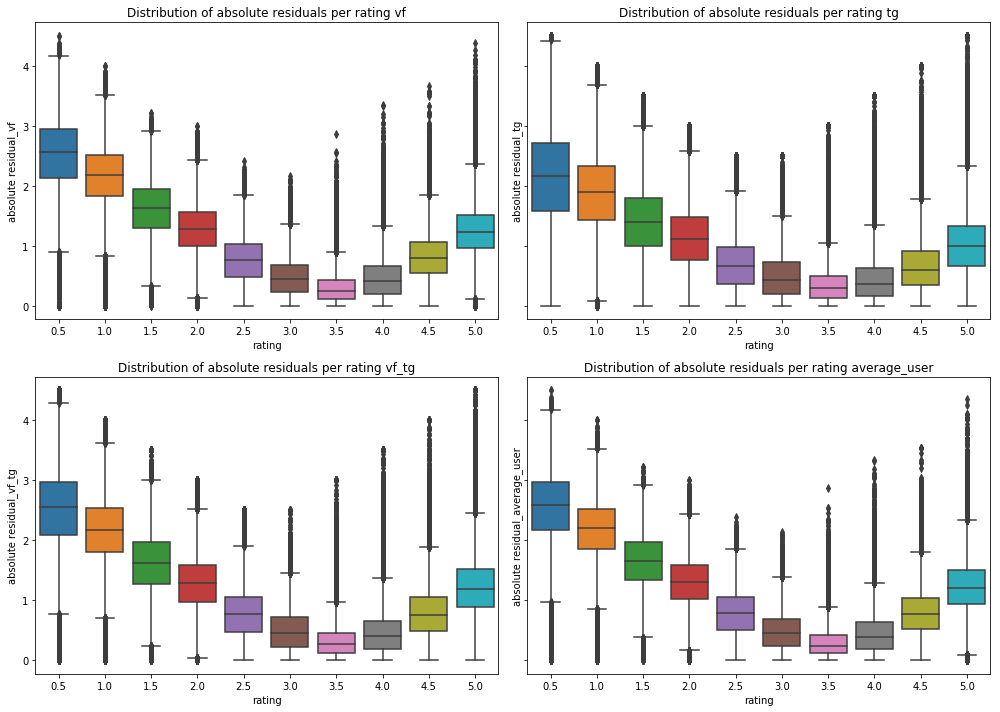

In [38]:
reload()
_ = tools.plot_side_by_side(tools.plot_absolute_residual_boxplot,
                            df_rating_pred=df_rating_test,
                            prediction_column_suffixes=prediction_column_suffixes)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


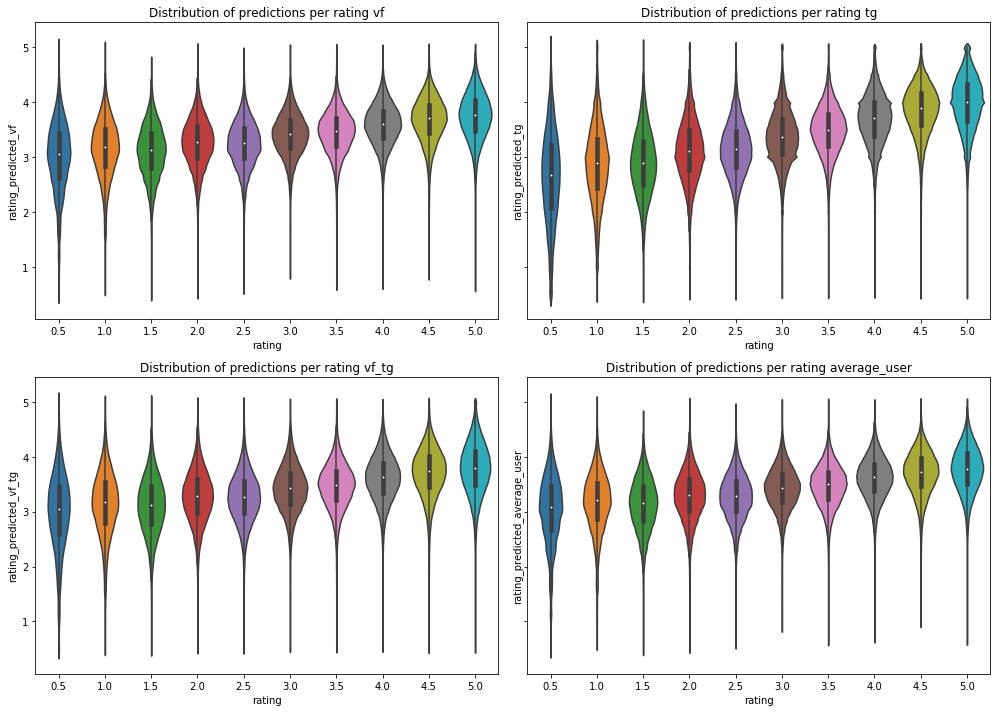

In [39]:
reload()
_ = tools.plot_side_by_side(tools.plot_actual_vs_predicted_violinplot,
                            df_rating_pred=df_rating_test,
                            prediction_column_suffixes=prediction_column_suffixes)

# Save the current notebook into results folder and push to the repository

In [ ]:
%%javascript
IPython.notebook.save_notebook()

In [ ]:
from notebook import notebookapp
import urllib
import json
import os
import ipykernel

currentTime = lambda : time.strftime('%Y-%m-%d-%H%M')

def notebook_path():
    """Returns the absolute path of the Notebook or None if it cannot be determined
    NOTE: works only when the security is token-based or there is also no password
    """
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[1].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  # No token and no password, ahem...
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+'api/sessions?token='+srv['token'])
            sessions = json.load(req)
            for sess in sessions:
                if sess['kernel']['id'] == kernel_id:
                    return os.path.join(srv['notebook_dir'],sess['notebook']['path'])
        except:
            pass  # There may be stale entries in the runtime directory 
    return None

notebook_dir, notebook_name = os.path.split(notebook_path())
output = os.path.join(notebook_dir, 'output', f'{notebook_name}_{currentTime()}.ipynb')
os.system(f'jupyter nbconvert --to ipynb {notebook_path()} --output {output}')
os.system(f'git add {output}')
os.system(f'git commit -m "result computed on {currentTime()}"')
os.system('git push')